In [1]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [2]:
image_path = './images/Cookie_theft_segmentation.png'
image = cv2.imread(image_path)

# Convert the image to RGB (OpenCV loads images in BGR format by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape(-1, 3)

# Use a KD-Tree to find unique colors within a threshold
threshold = 5
tree = cKDTree(pixels)
unique_colors = []
labels = np.zeros(pixels.shape[0], dtype=int) - 1

for i, pixel in enumerate(pixels):
    if labels[i] == -1:
        indices = tree.query_ball_point(pixel, threshold)
        unique_colors.append(pixel)
        labels[indices] = len(unique_colors) - 1

unique_colors = np.array(unique_colors)

# Print unique colors
print(f"Unique colors (within threshold): {unique_colors}")

Unique colors (within threshold): [[  0   0   0]
 [255   0   0]
 [  0   0 255]
 [128   0   0]
 [255 255   0]
 [  0 255 255]
 [255 128   0]
 [128 128   0]
 [255   0 255]
 [  0 128 128]
 [128 128 128]
 [  0 255   0]
 [  0   0 128]
 [  0 128   0]]


In [3]:
# Create a dictionary mapping from color tuples to segment labels
color_to_label = {tuple(color): label for label, color in enumerate(unique_colors)}

# Print the mapping
print(f"Color to label mapping: {color_to_label}")


Color to label mapping: {(0, 0, 0): 0, (255, 0, 0): 1, (0, 0, 255): 2, (128, 0, 0): 3, (255, 255, 0): 4, (0, 255, 255): 5, (255, 128, 0): 6, (128, 128, 0): 7, (255, 0, 255): 8, (0, 128, 128): 9, (128, 128, 128): 10, (0, 255, 0): 11, (0, 0, 128): 12, (0, 128, 0): 13}


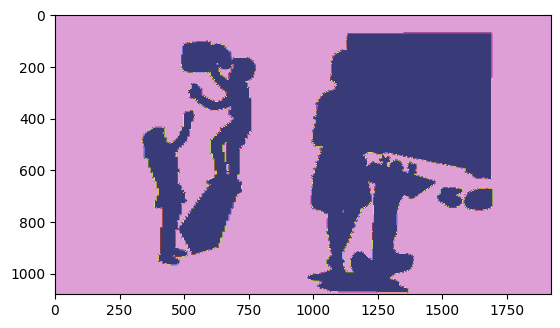

0


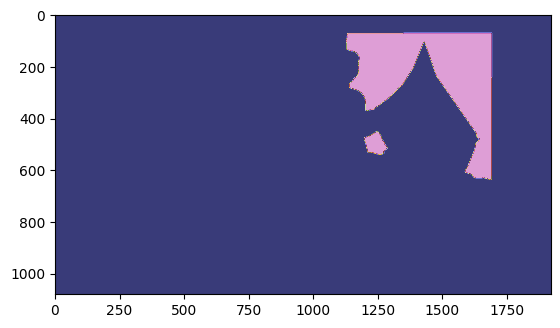

1


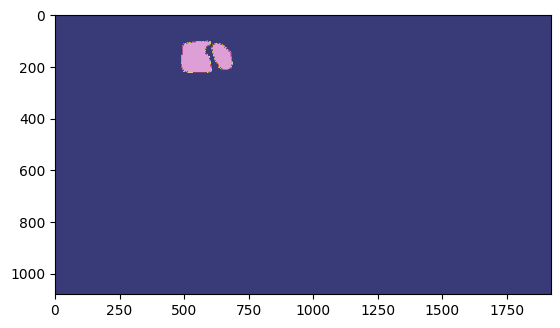

2


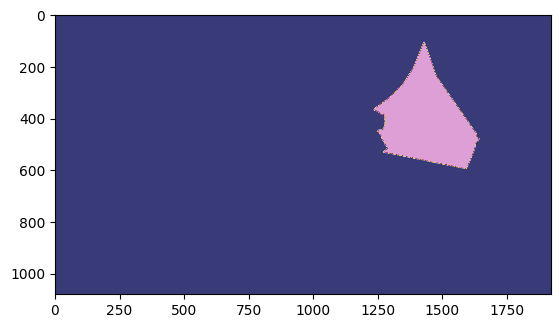

3


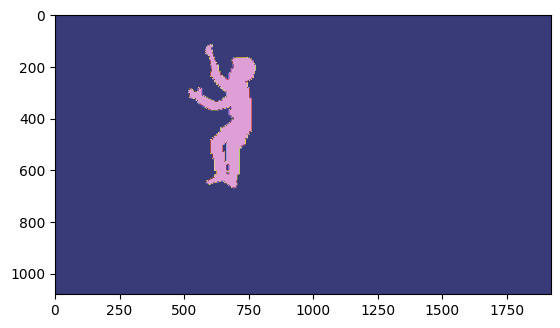

4


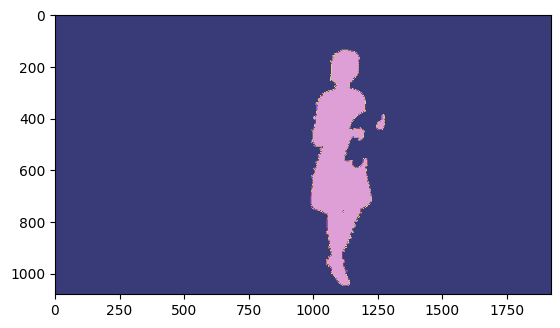

5


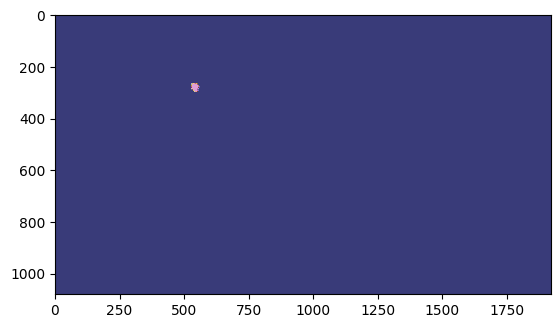

6


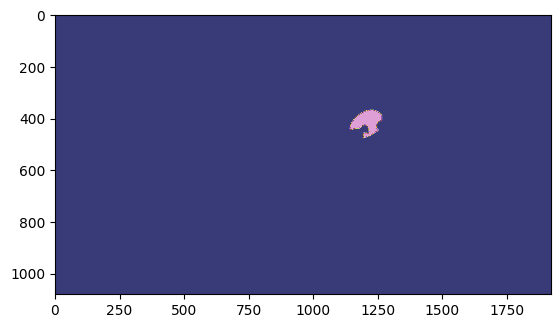

7


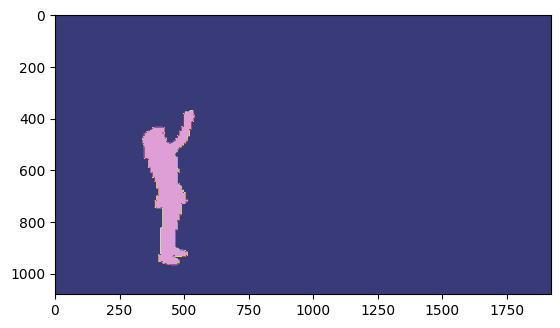

8


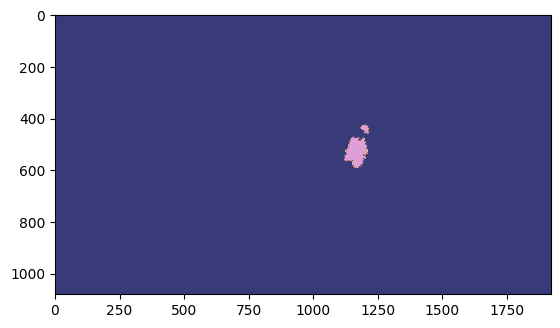

9


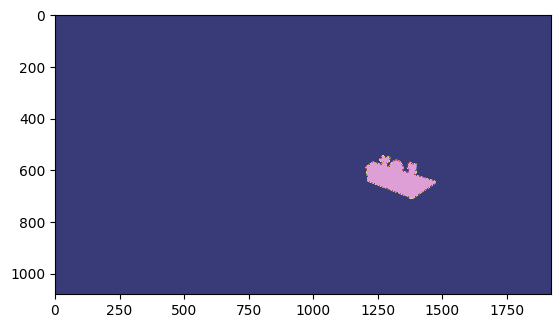

10


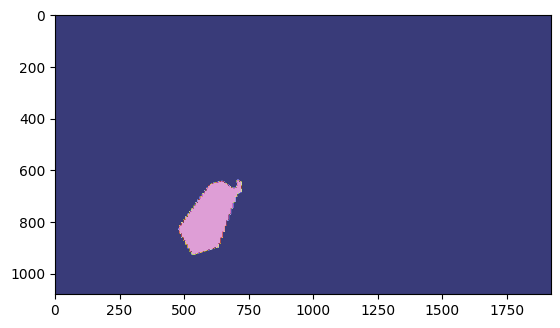

11


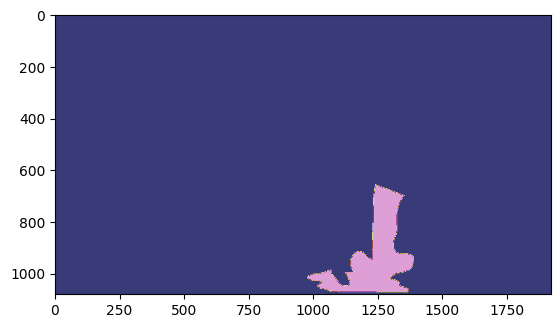

12


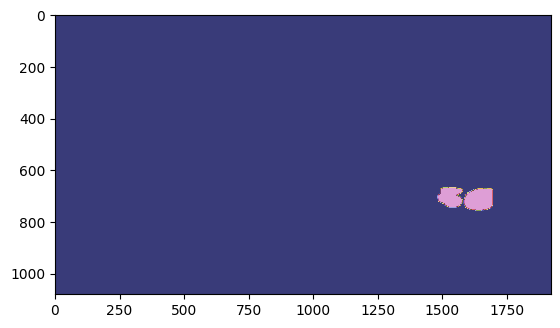

13
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
# Initialize the segmented mask with the same height and width as the input image
segmented_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.int32)

# Assign labels to each pixel based on the color
for i, color in enumerate(unique_colors):
    mask = np.all(image_rgb==color, axis=-1)
    plt.imshow(mask, cmap='tab20b')
    plt.show()
    print(i)
    segmented_mask[mask] = i

# Print the segmented mask
print(segmented_mask)


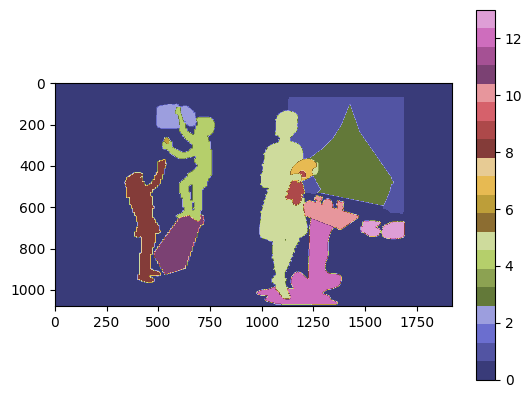

In [5]:
import matplotlib.pyplot as plt

plt.imshow(segmented_mask, cmap='tab20b')
plt.colorbar()
plt.show()


In [6]:
mask_id_list = np.unique(segmented_mask)
mask_id_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [7]:
image_component_id_lookup = {
    0: "Surrounding",
    1: "Curtain",
    2: "Cookie Jar",
    3: "Window",
    4: "Boy",
    5: "Lady",
    6: "Cookie",
    7: "Plate",
    8: "Girl",
    9: "Wash Cloth",
    10: "Sink",
    11: "Stool",
    12: "Water",
    13: "Dishes",
    14: "Image Components"
}

id: 0, tag: Surrounding
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


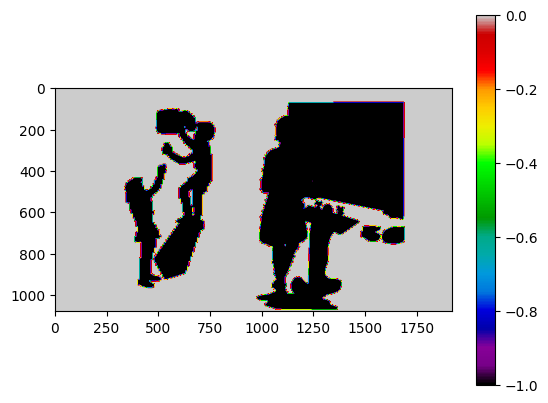

id: 1, tag: Curtain
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


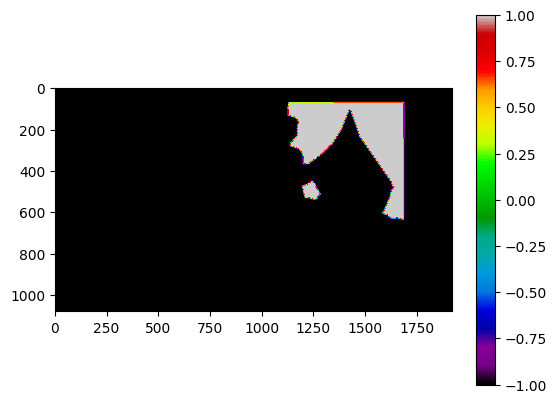

id: 2, tag: Cookie Jar
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


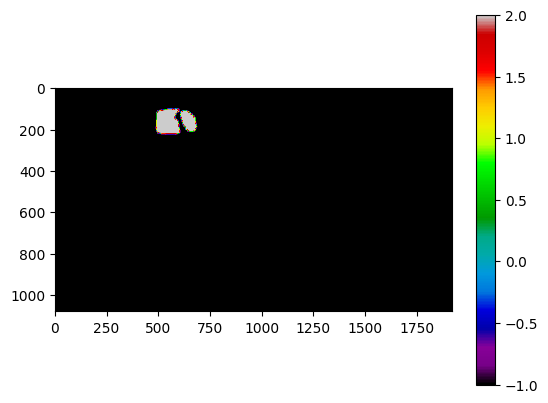

id: 3, tag: Window
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


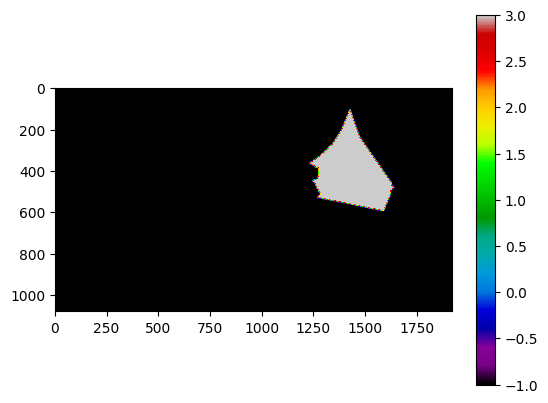

id: 4, tag: Boy
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


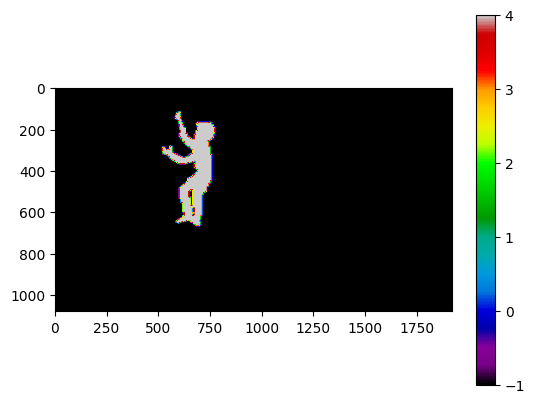

id: 5, tag: Lady
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


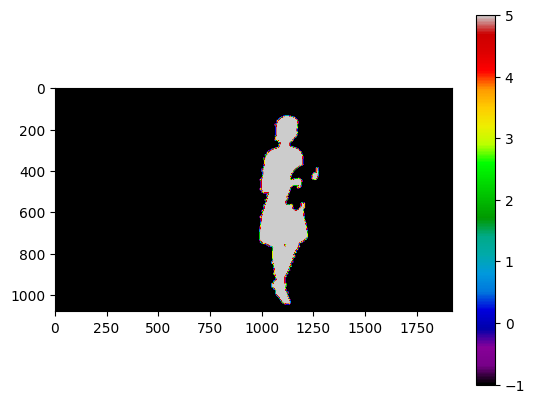

id: 6, tag: Cookie
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


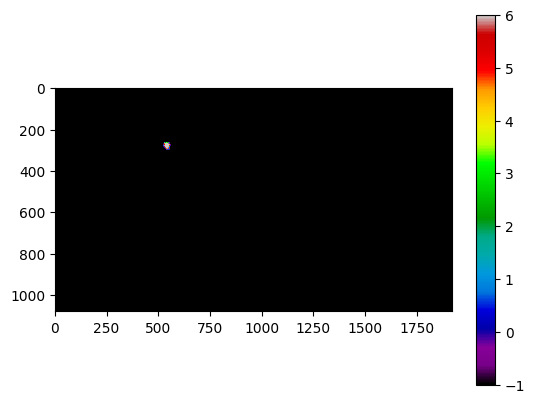

id: 7, tag: Plate
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


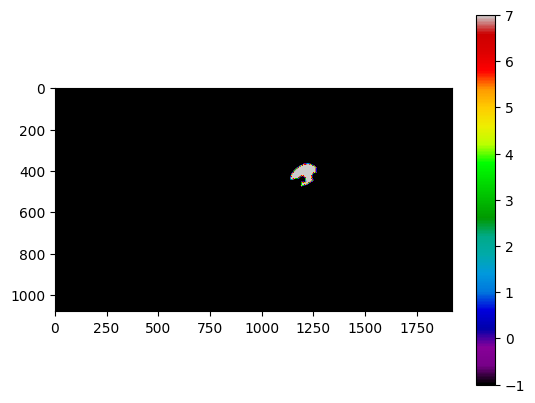

id: 8, tag: Girl
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


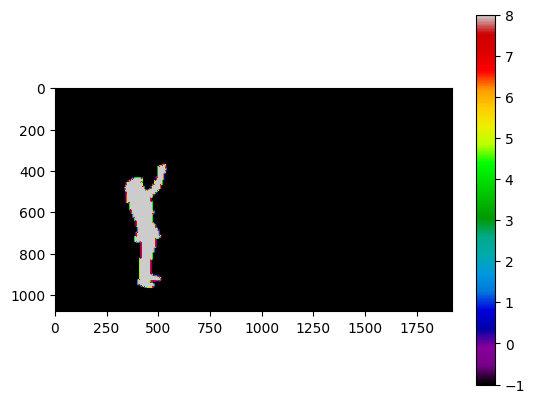

id: 9, tag: Wash Cloth
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


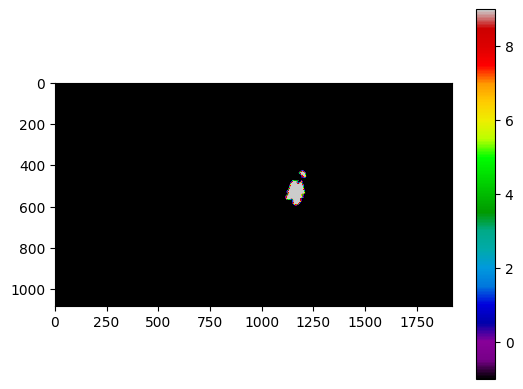

id: 10, tag: Sink
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


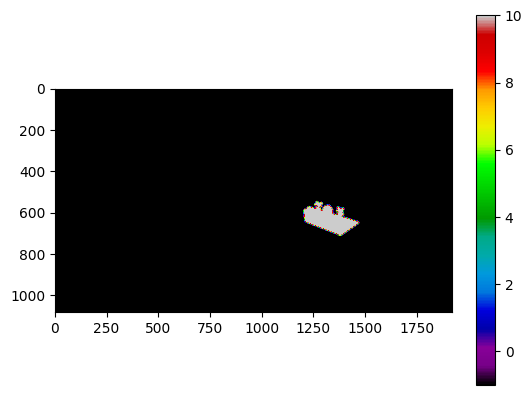

id: 11, tag: Stool
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


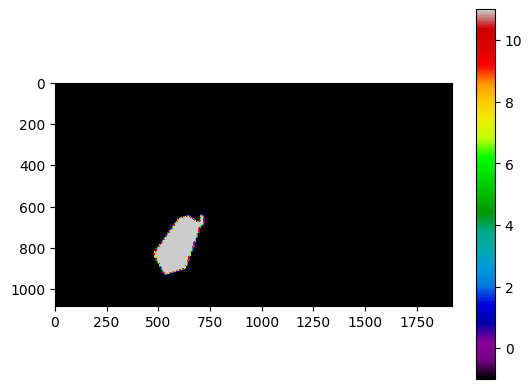

id: 12, tag: Water
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


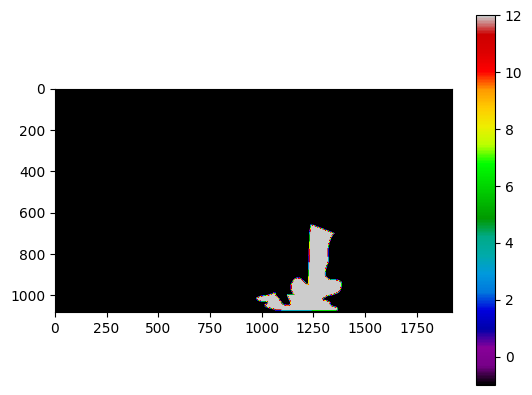

id: 13, tag: Dishes
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


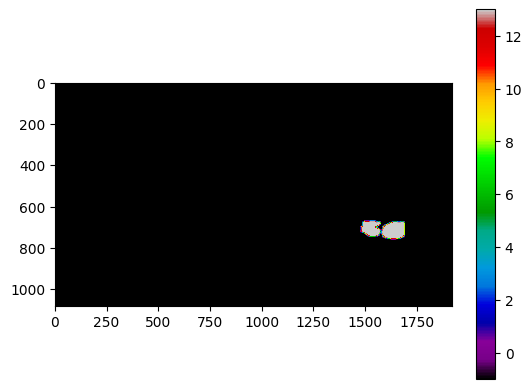

In [8]:
for id in mask_id_list:
    isolated_mask = segmented_mask.copy()
    isolated_mask[isolated_mask != id] = -1
    print(f"id: {id}, tag: {image_component_id_lookup[id]}")
    print(isolated_mask)
    plt.imshow(isolated_mask, cmap='nipy_spectral')
    plt.colorbar()
    plt.show()

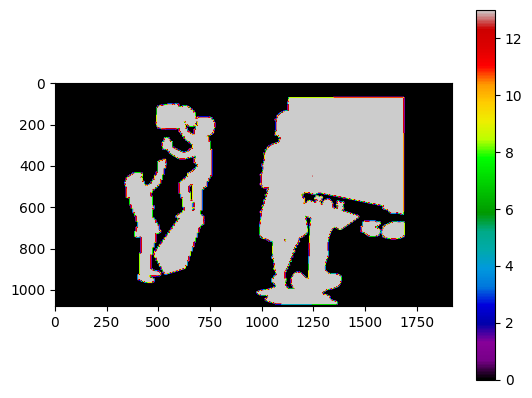

In [9]:
image_component_mask = segmented_mask.copy()
image_component_mask[image_component_mask != 0] = 13
plt.imshow(image_component_mask, cmap='nipy_spectral')
plt.colorbar()
plt.show()